In [1]:
%config Completer.use_jedi = False


import utils

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patheffects as path_effects
from matplotlib.colors import LightSource
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib as mpl

import numpy as np
import os
import shapefile
from cmcrameri import cm 
from netCDF4 import Dataset

from scipy.interpolate import griddata
import scipy.io as io

import pandas as pd

import obspy
from pyrocko.plot import beachball

from geographiclib.geodesic import Geodesic
geod = Geodesic.WGS84

figsize = (5.6, 5.6)

figdir = '../figures'
os.makedirs(figdir, exist_ok=True)

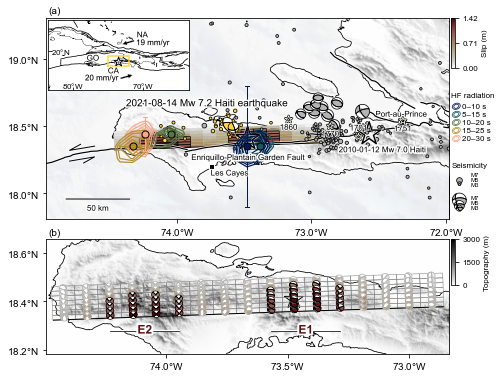

In [2]:
# slip model 
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))
elat, elon = model_para.lat[0], model_para.lon[0]
fig = plt.figure(figsize=figsize)
######################################################################################
###  map  ############################################################################
######################################################################################
# basemap and bathymetry
axpxloc, axpyloc, axpwidth, tickintx, tickinty, tickformat = 0.1, 0.1, 1, 1, 0.5, 1
lonmin, lonmax, latmin, latmax = lonminb, lonmaxb, latminb, latmaxb = elon-1.5, elon+1.5, elat-0.6, elat+0.9
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,rsphere=(6378137.00,6356752.3142),resolution='f',projection='cyl')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=abs(max(x)-min(x))/abs(max(y)-min(y))
axpheight=axpwidth/aspect
ax=fig.add_axes([axpxloc, axpyloc, axpwidth, axpheight])
axp = ax.get_position()
fig.text(axp.x0+0.005, axp.y1+0.005, '(a)', va='bottom', ha='left')
m.fillcontinents(color='w', zorder=0, alpha=0.5)
m.drawcoastlines(color='k', linewidth=0.75, zorder=1)
ax2 = utils.mapTicksBasemap(fig,m,ax,tickintx,tickinty,lonmin,lonmax,latmin,latmax,tickformat)

# basic information
utils.drawtopobathy(fig, ax, m, '../../GEBCO_17_Aug_2021_03734633048a/gebco_2021_n21.0_s17.0_w-76.0_e-69.0.nc', 0)
utils.drawseismicity(ax, m, elon, elat)
utils.drawbeachball(ax, m, '../materials/work/SPUD_QUAKEML_bundle.xml')
utils.drawactivefault(ax, m, 2, '../materials/work/gem-global-active-faults/shapefile/gem_active_faults.shp')
utils.drawtexts(ax, m, elat, elon, lonmin, lonmax, latmin, latmax)
utils.drawinsetmap(fig, ax, m, elon, elat, lonminb, lonmaxb, latminb, latmaxb, '../materials/work/gem-global-active-faults/shapefile/gem_active_faults.shp')

# slip model
cmap = cm.bilbao
dx, dy = model_para.xx[0], model_para.yy[0]
model_stk, model_dip = model_para.strike[0], model_para.dip[0]
nx, ny, x0, y0 = model_para.mn[0], model_para.nn[0], model_para.m0[0], model_para.n0[0]
lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
tmp = np.argsort(slip)
lon = [ lon[i] for i in tmp ]
lat = [ lat[i] for i in tmp ]
slip = [ slip[i] for i in tmp ]
dep = [ dep[i] for i in tmp ]
for i in range(len(lat)):
    xslipcell, yslipcell = utils.getFFMslipcell(lat[i], lon[i], dx, dy, model_stk, model_dip, m)
    ax.fill(xslipcell, yslipcell, facecolor=cmap(slip[i]/max(slip)), zorder=1, edgecolor='C7', lw=0.1)
    if slip[i] > max(slip)*0.5:
        ax.fill(xslipcell, yslipcell, facecolor='none', zorder=1, edgecolor='k', lw=0.75)
        

utils.drawFFMmodeltop(dx, dy, nx, ny, x0, y0, model_dip, model_stk, elat, elon, m, ax, 1)
axp = ax.get_position()
cax=fig.add_axes([axp.x1+0.005, axp.y1-axp.height*0.25, 0.01, axp.height*0.25])
norm=mpl.colors.Normalize(vmin=0, vmax=max(slip))
cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, 
                             ticks=np.linspace(0, max(slip), 3), format='%.2f')
cb.ax.tick_params(labelsize=8)
cb.set_label(label='Slip (m)', fontsize=8)

# back-projection
lon, lat = np.loadtxt('../materials/bp/lonlat.txt', unpack=True)
peaklon, peaklat = np.loadtxt('../materials/bp/bppeakloci.txt', unpack=True, usecols=(0,1))
ja_dis, ja_lat, ja_lon = np.loadtxt('../materials/bp/jackknife.txt', unpack=True)

x, y = m(lon, lat)
levels = np.arange(90, 100+2, 2)
colors = cm.batlow(np.linspace(0,1,5+1))
for iwin in range(5):
    bpamp = np.loadtxt('../materials/bp/rms'+str(iwin)+'.txt')
    sc = ax.contour(x, y, bpamp, levels=levels, colors=colors[iwin].reshape(-1,4), linewidths=1.2, alpha=1, zorder=int(100-iwin))

    tmpx, tmpy = peaklon[iwin], peaklat[iwin]
    ax.scatter(tmpx, tmpy, facecolor=colors[iwin], edgecolor='k', linewidth=1, s=50, alpha=1, zorder=102)

    tmp = geod.Inverse(elat, elon, tmpy, tmpx)
    x0, y0 = tmp['lon1'], tmp['lat1']
    x1, y1 = tmp['lon2'], tmp['lat2']
    azi = -tmp['azi1']
    
    tmp = geod.Direct(tmpy, tmpx, azi, ja_dis[iwin]*1e3)
    x0, y0 = tmp['lon1'], tmp['lat1']
    x1, y1 = tmp['lon2'], tmp['lat2']
        
    for pm in [-1, 1]:
        ax.plot([tmpx, tmpx+ja_lon[iwin]*pm], [tmpy, tmpy], zorder=101, color=colors[iwin], linewidth=1)
        ax.plot([tmpx, tmpx], [tmpy, tmpy+ja_lat[iwin]*pm], zorder=101, color=colors[iwin], linewidth=1)
        
        for _pm in [-1, 1]:
            tmp = geod.Direct(tmpy, tmpx+ja_lon[iwin]*pm, 0, _pm * 1.5*1e3)
            x0, y0 = tmp['lon1'], tmp['lat1']
            x1, y1 = tmp['lon2'], tmp['lat2']
            ax.plot([x0,x1], [y0,y1], color=colors[iwin], zorder=101, linewidth=1)
        
            tmp = geod.Direct(tmpy+ja_lat[iwin]*pm, tmpx, 90, _pm * 1.5*1e3)
            x0, y0 = tmp['lon1'], tmp['lat1']
            x1, y1 = tmp['lon2'], tmp['lat2']
            ax.plot([x0,x1], [y0,y1], color=colors[iwin], zorder=101, linewidth=1)

# legend
utils.drawlegend(fig, ax, m)

######################################################################################
###  close up map  ###################################################################
######################################################################################
# basemap and bathymetry
axp = ax.get_position()
axpxloc, axpyloc, axpwidth = axp.x0, axp.y0, 1
tickintx, tickinty, tickformat = 0.5, 0.2, 1
lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
lonmin, lonmax, latmin, latmax = lonminb, lonmaxb, latminb, latmaxb = min(lon)-0.07, max(lon)+0.07, min(lat)-0.15, max(lat)+0.15
m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,rsphere=(6378137.00,6356752.3142),resolution='f',projection='cyl')
x, y=m([lonmin, lonmax], [latmin, latmax])
aspect=abs(max(x)-min(x))/abs(max(y)-min(y))
axpheight=axpwidth/aspect
axpyloc = axp.y0-axpheight-0.05
ax=fig.add_axes([axpxloc, axpyloc, axpwidth, axpheight])
axp = ax.get_position()
fig.text(axp.x0+0.005, axp.y1+0.005, '(b)', va='bottom', ha='left')
m.fillcontinents(color='w', zorder=0, alpha=0)
m.drawcoastlines(color='k', linewidth=0.75, zorder=1)
ax2 = utils.mapTicksBasemap(fig,m,ax,tickintx,tickinty,lonmin,lonmax,latmin,latmax,tickformat)

# topography
utils.drawdetailtopography(fig, ax, m, '/Volumes/WDMyPassport4TB20210316/2021Haiti/earth_at_2m.grd')

# initial rupture point
x, y = m(elon, elat)
sc=ax.scatter(x, y, s=400, marker='*', facecolor='none', edgecolor='k', alpha=1, lw=1, zorder=1, 
              path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

# draw beachball
cmap = cm.bilbao
dx, dy = model_para.xx[0], model_para.yy[0]
model_stk, model_dip = model_para.strike[0], model_para.dip[0] # <-- this is just for the visualization purpose
nx, ny, x0, y0 = model_para.mn[0], model_para.nn[0], model_para.m0[0], model_para.n0[0]
lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
tmp = np.argsort(slip)
lon = [ lon[i] for i in tmp ]
lat = [ lat[i] for i in tmp ]
slip = [ slip[i] for i in tmp ]
dep = [ dep[i] for i in tmp ]
for i in range(len(lat)):
    xslipcell, yslipcell = utils.getSlipCell(lat[i], lon[i], dx, dy, model_stk, model_dip, m)
    ax.fill(xslipcell, yslipcell, facecolor='none', zorder=1, edgecolor='gray', lw=0.5)

utils.plotModelTop(dx, dy, nx, ny, x0, y0, model_dip, model_stk, elat, elon, m, ax, 10)    

data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'FFM_DCall.txt'), skiprows=1)
lon,lat,dep,slip = data[:,1],data[:,2],data[:,3],data[:,4]
strike0,dip0,rake0,strike1,dip1,rake1 = data[:,5],data[:,6],data[:,7],data[:,8],data[:,9],data[:,10]
xloc,yloc = data[:,11],data[:,12]

data=np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'FFM_MT.txt'))
m1,m2,m3,m4,m5,m6 = data[:,4],data[:,5],data[:,6],data[:,7],data[:,8],data[:,9]

x, y = m(lon, lat)
for i in range(len(slip)):

    focmec = [m1[i],m2[i],m3[i],m4[i],m5[i],m6[i]]
    focmec = utils.convertUSEtoNED(focmec)
    
    if slip[i] > max(slip)*0.5:
        edgecolor='k'
    else:
        edgecolor='C7'
    
    tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*0.75, position=(x[i], y[i]),
                             beachball_type='deviatoric', edgecolor='none', color_t=cmap(slip[i]/max(slip)),
                             color_p='w', linewidth=0.75, alpha=1, zorder=11+int(slip[i]/max(slip)*100), view='top')
    tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*0.75, position=(x[i], y[i]),
                             beachball_type='dc', edgecolor=edgecolor, color_t='none',
                             color_p='none', linewidth=0.75, alpha=1, zorder=11+int(slip[i]/max(slip)*100), view='top')

# episode labels
cmap = cm.bilbao
lat0 = 18.28
e1lon0, e1lon1 = -73.568123, -73.284416
e2lon0, e2lon1 = -74.229958, -73.946327
for lon0, lon1, label in zip([e1lon0,e2lon0], [e1lon1,e2lon1], ['E1', 'E2']):
    ax.plot([lon0, lon1], [lat0, lat0], color='k', lw=0.75,
            path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
    ax.text(lon0+(lon1-lon0)/2, lat0, label, va='center', ha='center', size=12, color=cmap(0.95), fontweight='bold',
            path_effects=[path_effects.Stroke(linewidth=4, foreground='w', alpha=1), path_effects.Normal()])

plt.savefig(os.path.join(figdir, 'fig1.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

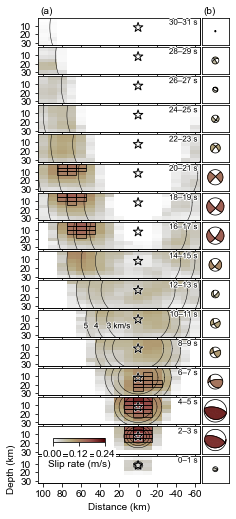

In [6]:
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))
######################################################################################
###  snapshots  ######################################################################
######################################################################################
fig=plt.figure(figsize=figsize)
axx0, axy0, axw = 0.1, 0.1, 0.4
data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'snap_1sec_meca_201.txt'), skiprows=1)
aspect = (np.max(data[:,0])-np.min(data[:,0])) / ( np.max(data[:,2]) - np.min(data[:,2]) )
axh = axw / aspect

maxsliprateall = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'snap_1sec_meca_201.txt'), usecols=8, skiprows=1)[0]

data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'tw_mec.dat'))
snap_t, str_total, dip_total, rake_total = data[:,0], data[:,9], data[:,11], data[:,13]
m1, m2, m3, m4, m5, m6 = data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]

cmap = cm.bilbao
for snap in np.arange(0, 31, 2):
    if snap == 0:
        ax = fig.add_axes([axx0, axy0, axw, axh])
        axp0 = ax.get_position()
    else:
        axx0, axy0 = axp.x0, axp.y0+axp.height+0.005
        ax = fig.add_axes([axx0, axy0, axw, axh])

    axp = ax.get_position()

    data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'FFM_DCall.txt'), skiprows=1)

    data=np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'snap_1sec_meca_'+str(200+snap+1)+'.txt'), skiprows=1)
    xloc, yloc, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
    strike0,dip0,rake0,strike1,dip1,rake1 = data[:,9],data[:,11],data[:,13],data[:,10],data[:,12],data[:,14]
    time_s, time_e = int(data[:,6][0]), int(data[:,7][0])

    fig.text(axp.x1-0.005, axp.y1-0.005, str(time_s)+'–'+str(time_e)+' s', va='top', ha='right', size=8, 
             path_effects = [path_effects.Stroke(linewidth=2, foreground='w'), path_effects.Normal()], zorder=1000)


    strike, dip, rake = [],[],[]
    for i in range(len(strike0)):
        tmpstr, tmpdip, tmprake = utils.selectplane(model_para.strike[0],model_para.dip[0],strike0[i],dip0[i],rake0[i],strike1[i],dip1[i],rake1[i])
        strike.append(tmpstr)
        dip.append(tmpdip)
        rake.append(tmprake)

    dx, dy = model_para.xx[0], model_para.yy[0]
    xmin, xmax = np.min(xloc)-dx/2, np.max(xloc)+dx/2
    ymin, ymax = np.min(yloc)-dy/2, np.max(yloc)+dy/2

    slip = avesliprate

    for i in np.arange(len(xloc)):
        tmpx, tmpy = xloc[i], yloc[i]
        tmpxlist = [tmpx-dx/2, tmpx+dx/2, tmpx+dx/2, tmpx-dx/2, tmpx-dx/2]
        tmpylist = [tmpy-dy/2, tmpy-dy/2, tmpy+dy/2, tmpy+dy/2, tmpy-dy/2]
        ax.fill(tmpxlist, tmpylist, facecolor=cmap(slip[i]/maxsliprateall), edgecolor='none', zorder=0)
        if slip[i] > 0.5 * maxsliprateall:
            ax.fill(tmpxlist, tmpylist, facecolor='none', edgecolor='k', zorder=1, lw=0.75)
            

    if model_para.icmn[0] == 5:
        axp = ax.get_position()
        axheight = axp.height
        axwidth = axheight
        axb = fig.add_axes([axp.x1+0.005, axp.y0, axwidth, axheight])
        axbp = axb.get_position()
        focmec=[str_total[snap], dip_total[snap], rake_total[snap]]
        color=cmap(np.max(slip)/maxsliprateall)
        tmp = beachball.plot_beachball_mpl(focmec, axb, size=dx*np.max(slip)/maxsliprateall*0.85*3, position=(0.5, 0.5),
                                 beachball_type='dc', edgecolor='k', color_t=color,
                                 color_p='w', linewidth=0.75, alpha=1, zorder=1)
        axb.set_xticks([])
        axb.set_yticks([])
        axb.patch.set_alpha(0.5)

    for vr in [3,4,5]:
        az = np.arange(-np.pi, np.pi, 0.01)
        x = np.cos(az) * time_e * vr
        y = np.sin(az) * time_e * vr
        ax.plot(x, y, color='k', lw=0.5, linestyle='-')
        if snap == 10:
            x = time_e * vr
            y = -dy * 1.8
            if vr == 3:
                text=ax.text(x, y, str(vr)+' km/s', size=8, 
                     color='k', ha='left', va='center', zorder=1001)     
            else:
                text=ax.text(x, y, str(vr), size=8, 
                     color='k', ha='center', va='center', zorder=1001)     
            text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w', alpha=0.75), path_effects.Normal()])

    ax.scatter(0, 0, marker='*', s=100, facecolor='none', edgecolor='k', 
               path_effects = [path_effects.Stroke(linewidth=2, foreground='w'), path_effects.Normal()])


    ax.set_xticks(np.arange(-120, 120, 20))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    if model_para.dip[0] > 0:
        ax2 = ax.twinx()
        depmin = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymin
        depmax = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymax
        ax2.set_ylim(depmin, depmax)

    if snap == 0:      
        ax2.set_ylabel('Depth (km)')
        ax.set_xlabel('Distance (km)')
        cax = fig.add_axes([axp.x0+0.035, axp.y0+0.1, 0.13, 0.01])
        norm = mpl.colors.Normalize(vmin=0, vmax=maxsliprateall)
        mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip rate (m/s)',
                                  ticks=np.linspace(0,maxsliprateall,3), format='%.2f', orientation='horizontal')
        cax.xaxis.labelpad = 1

        props = dict(facecolor='w', alpha=1, edgecolor='none', boxstyle='square,pad=0.1')
        for label in cax.get_xticklabels():
            label.set_bbox(props)
        cax.xaxis.get_label().set_bbox(props)
        cax.set_zorder(100)

    else:
        ax.set_xticklabels([])

    ax.set_yticks([])
    ax2.yaxis.set_ticks_position('left')
    ax2.yaxis.set_label_position('left')
    ax.invert_xaxis()
    ax.set_zorder(100-snap)


axp = ax.get_position()
props = dict(facecolor='w', alpha=0.85, edgecolor='none', boxstyle='square,pad=0.1')
fig.text(axp.x0+0.005, axp.y1+0.005, '(a)', va='bottom', ha='left')
fig.text(axbp.x0+0.005, axbp.y1+0.005, '(b)', va='bottom', ha='left')

plt.savefig(os.path.join(figdir, 'snap.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300)        
plt.show()

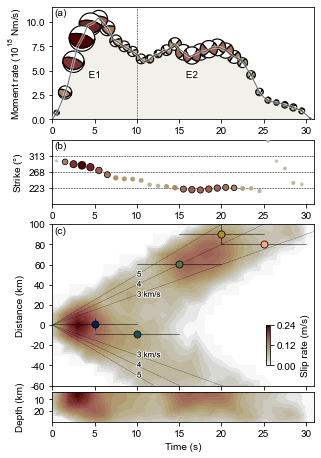

In [2]:
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))

fig=plt.figure(figsize=figsize)
ax = fig.add_axes([0.1, 0.1, 0.65, 0.28])
axp = ax.get_position()
fig.text(axp.x0+0.005, axp.y1-0.005, '(a)', va='top', ha='left')

cmap = cm.bilbao

data=np.loadtxt('../materials/ffm/model_'+model+'/st_'+model+'.dat')
t, amp=data[:,0], data[:,1]
vr = model_para['vr'][0]
ax.plot(t, amp, color='k', label='Vr '+str(vr)+' km/s', lw=1, zorder=1001, alpha=0.55, 
        path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=0.55), path_effects.Normal()])
ax.fill(t, amp, color=cmap(0.3), alpha=0.2)


maxsliprateall = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'snap_1sec_meca_201.txt'), usecols=8, skiprows=1)[0]
data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'tw_mec.dat'))
snap_t, str_total, dip_total, rake_total = data[:,0], data[:,9], data[:,11], data[:,13]
m1, m2, m3, m4, m5, m6 = data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]
dx, dy = model_para.xx[0], model_para.yy[0]

for snap in range(0, 31, 1):
    data=np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'snap_1sec_meca_'+str(200+snap+1)+'.txt'), skiprows=1)
    xloc, yloc, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
    slip = avesliprate
    focmec=[str_total[snap], dip_total[snap], rake_total[snap]]
    color=cmap(np.max(slip)/maxsliprateall)
    tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*np.max(slip)/maxsliprateall*0.85*3, position=(t[np.where(t==snap+0.5)], amp[np.where(t==snap+0.5)]),
                             beachball_type='dc', edgecolor='k', color_t=color,
                             color_p='w', linewidth=1.2, alpha=1, zorder=int(np.max(slip)/maxsliprateall*100))
    tmp.set_clip_on(False)
    
ax.axvline(10, linestyle='--', lw=0.5, color='k', zorder=0)
ax.text(5, 4.5, 'E1', ha='center', va='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=1), path_effects.Normal()])
ax.text(16.5, 4.5, 'E2', ha='center', va='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=1), path_effects.Normal()])

ax.set_xlim(0, snap+1)
ax.set_ylim(0, 11.6)

ax.set_ylabel('Moment rate '+r'($10^{18}$ Nm/s)', labelpad=0.5)
#ax.set_xlabel('Time (s)')


# strike evo
refazi = 268
axp = ax.get_position()
ax = fig.add_axes([axp.x0, axp.y0-0.16-0.05, axp.width, 0.16])
utils.strikeevo(model, ax, refazi)
#ax.text(20, 268, 'EPGF', size=6, color='k', ha='center', va='center', zorder=1001,
#             path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
ax.set(xlabel='')

axp = ax.get_position()
fig.text(axp.x0+0.005, axp.y1-0.005, '(b)', va='top', ha='left')


axp = ax.get_position()
ax = utils.plotTimeEvo(fig, model, axp.x0, axp.y0-0.4-0.05, 0.65, 0.4)
ax.set_xlim(0, snap+1)
ax.set_xticklabels([])


# snapshot
peaklon, peaklat = np.loadtxt('../materials/bp/bppeakloci.txt', unpack=True, usecols=(0,1))
data = np.loadtxt('../materials/bp/jackknife.txt')
ja_dis, ja_lat, ja_lon = data[:,0], data[:,1], data[:,2]

winnum1 = 5
colors = cm.batlow(np.linspace(0,1,winnum1+1))

Fs = 100
ts = 5
t1 = 10

iwinstep = ts*Fs
iwinlen = t1*Fs
for i in range(winnum1):
    
    wstp = i * iwinstep
    wedp = wstp + iwinlen
    centertime = wstp/Fs+(wedp/Fs-wstp/Fs)/2
    
    tmpdis, tmpdis_ref, proj_theta = utils.project_on_ref_fault(model_para.lat[0], model_para.lon[0], peaklat[i], peaklon[i], model_para.strike[0])
    
    alpha=1
    ax.scatter(centertime, tmpdis_ref, facecolor=colors[i], edgecolor='k', linewidth=0.75, zorder=2, s=50, alpha=alpha)
    ax.plot([centertime-t1/2, centertime+t1/2], [tmpdis_ref, tmpdis_ref], linewidth=0.5, color='k', zorder=1, alpha=alpha)
    
    proj_ja_dis = ja_dis[i] * np.cos(np.deg2rad(proj_theta))
    ax.plot([centertime, centertime], [tmpdis_ref+proj_ja_dis, tmpdis_ref-proj_ja_dis], linewidth=0.5, color='k', zorder=1, alpha=alpha)
    
scale = (max(yloc)-min(yloc))/(max(xloc)-min(xloc))
axp = ax.get_position()
ax = utils.plotTimeEvoDip(fig, model, axp.x0, axp.y0-axp.height*scale-0.015, axp.width, axp.height*scale)
ax.set_xlim(0, snap+1)
fig.text(axp.x0+0.005, axp.y1-0.005, '(c)', va='top', ha='left')

plt.savefig(os.path.join(figdir, 'evo.png'), bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

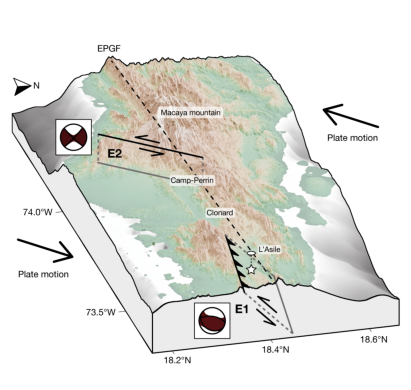

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(5, 5))
image = mpimg.imread('../figures/schematic.png')
ax = fig.add_axes([0, 0, image.T.shape[1]*1e-3, image.T.shape[2]*1e-3])
ax.imshow(image)
ax.axis('off'); plt.show()

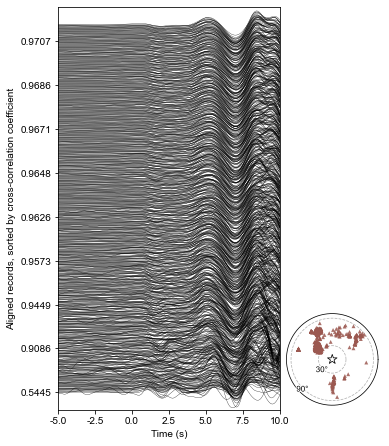

In [2]:
BP = io.loadmat('../materials/bp/Haiti_EV1_BP1.mat')
AL = io.loadmat('../materials/bp/Haiti_EV1_AL1_2.mat')
station_loc_all = BP['SEIS']['STLOCS'][0][0]

cccut = 0.6
BDLIST = np.hstack(AL['AL'][0][0]['BDLIST'][0][0])
GDlist0 = (1-BDLIST).ravel().nonzero()
RAVG = np.hstack(AL['AL'][0][0]['RAVG'][0][0])
tmpidx = RAVG.ravel().nonzero()
tmpidx = np.where(RAVG[tmpidx]>cccut)
GDlist = np.intersect1d(GDlist0, tmpidx)
station_loc = BP['SEIS']['STLOCS'][0][0][GDlist]


def aziequiBP(ax, station_loc_all, elat, elon):
    
    cmap = plt.get_cmap('coolwarm')
    cmap = cm.bilbao
    for j in range(len(station_loc_all)):
        tmp = geod.Inverse(elat, elon, station_loc_all[j][0], station_loc_all[j][1])
        d = tmp['a12']
        a = 90-tmp['azi1']
        x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
        sc=ax.scatter(x, y, s=15, marker='^', edgecolor='none', lw=0.5, facecolor=cmap(0.7), alpha=0.85, zorder=10)
        
    ax.scatter(0, 0, s=100, marker='*', edgecolor='k', facecolor='none', lw=0.75)
    theta=np.linspace(0, 360, 360)
    for i in [30, 90]:
        x, y=(i*np.cos(theta*np.pi/180.0), i*np.sin(theta*np.pi/180.0))
        ax.plot(x, y, color='C7', zorder=0, solid_capstyle='round', lw=0.75, linestyle='--')
        x, y=(i*np.cos(-135*np.pi/180.0), i*np.sin(-135*np.pi/180.0))
        text = ax.text(x, y, str(i)+'$\degree$', size=8, va='center', ha='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

    x, y=(100*np.cos(theta*np.pi/180.0), 100*np.sin(theta*np.pi/180.0))
    ax.plot(x, y, color='k', solid_capstyle='round', lw=0.75)
    ax.fill(x, y, edgecolor='none', facecolor='w', zorder=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([]) 
    return sc


models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))
elat, elon = model_para.lat[0], model_para.lon[0]

fig = plt.figure(figsize=figsize)    
ax = fig.add_axes([0.1, 0.1, 0.55, 1])
Fs = 100

timelim0 = -10
timelim = 15

t0 = Fs*30
lent = (timelim+0.1)*Fs+t0
timeaix = np.arange(0, int(lent), 1)/Fs-t0/Fs


tt = np.hstack(AL['AL'][0][0]['TT'][0][0])
pols = np.hstack(AL['AL'][0][0]['POLS'][0][0])
RAVG = np.hstack(AL['AL'][0][0]['RAVG'][0][0])
seis_bp0 = BP['SEIS']['SEIS_BP0'][0][0]
traceamp = 2

tmpind = np.argsort(RAVG)
scale = 0
coef_list_for_label = []
for j in tmpind:
    
    stp1 = int(Fs*60-t0+tt[j])
    edp1 = int(stp1 + lent)
    
    amp = seis_bp0[j,:]
    amp = amp[stp1:edp1]/max(abs(amp[stp1:edp1])) * traceamp * pols[j]

    amp = amp*20 + scale
    
    color = 'k'
    ax.plot(timeaix, amp, lw=0.3, zorder=1, color=color)
    
    scale += 1
    
ax.set_xlim(-5, 10)
ax.set_ylim(-40, scale+40)
yticks = np.arange(0, len(tmpind), 100)
ax.set_yticks(yticks)
labels = [ RAVG[j] for j in tmpind[yticks] ]
ax.set_yticklabels(labels)
ax.set_ylabel('Aligned records, sorted by cross-correlation coefficient')
ax.set_xlabel('Time (s)')

axp = ax.get_position()
ax = fig.add_axes([axp.x1+0.005, axp.y0, 0.25, 0.25])
sc = aziequiBP(ax, station_loc_all, elat, elon)

plt.savefig(os.path.join(figdir, 'bptrace.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300, facecolor='w')
plt.show()

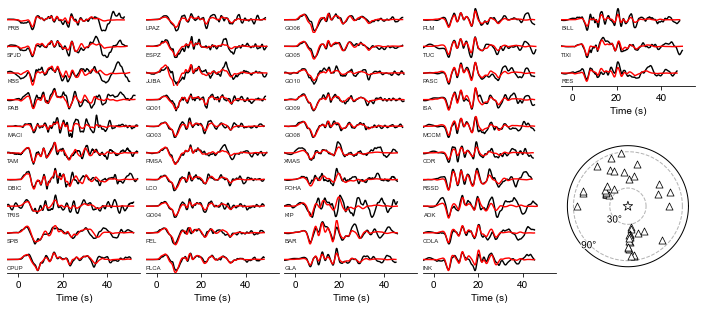

In [7]:
def drawobssyn(ax, obsdata, syndata, alpha):
    data=np.loadtxt(obsdata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C7', lw=0.2, alpha=alpha)
    data=np.loadtxt(syndata, usecols=(0, 1))
    t, amp=(data[:,0]-5, data[:,1])
    ax.plot(t, amp, color='C3', lw=0.2, alpha=alpha)
def fittings(sta, x0, y1, width, height, modelid, dep, mint, maxt, numwave, cmap, maxdepofcolor, flag, azi, dis):
    j=0
    for i in np.arange(0, len(modelid), 1):
        ax=fig.add_axes([x0,y1-height*j,width,height])
        drawobssyn(ax, '../materials/ffm/model_'+modelid+'/obssyn/obs_'+sta+'.txt', \
                   '../materials/ffm/model_'+modelid+'/obssyn/syn_'+sta+'.txt', 0.85)
        cmap=plt.get_cmap('RdYlBu')
        color = cmap(dep[i]/maxdepofcolor)
        if flag == 1:
            ax.scatter(mint, 0, s=20, marker='*', edgecolor='C7', lw=0.3, zorder=20, color=color, clip_on=False)
            #ax.text(-5, -0.3, r'$h_{0}$='+str('%.1f' % dep[i]), ha='left', va='top', size=6, color='C7')
        ax.set_xlim([mint, maxt])
        ax.set_ylim([-1, 1])
#        ax.plot([0, 0],[-1, 1], lw=0.1)
        if i==0:
            ax.text(mint, 1, sta+'\nAz.='+str(azi)+'$\degree$\nDel.='+str(dis)+'$\degree$', \
                    va='bottom', ha='left', size=6, color='C7', clip_on=False)
        #if i==numwave-1:
        if i==12:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([0, 30, 60])
            ax.set_xticklabels([0, 30, 60], size=6)
            ax.set_xlabel('Time (s)', size=6)
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([])
        j+=1
    return ax, cmap

def plotFit(modelid, outputfile):
    w = 7.4; h = 7.4; wh=w/h
    fig=plt.figure(figsize=(w, h))
    alpha=0.85
    axw=0.25
    axh=0.05
    stalist=np.loadtxt('../materials/ffm/model_'+str(modelid)+'/station_'+str(modelid)+'.list', usecols=(0), dtype=str)
    stadata=np.loadtxt('../materials/ffm/model_'+str(modelid)+'/station_'+str(modelid)+'.list', usecols=(4, 5))
    datalen = np.loadtxt('../materials/ffm/model_'+str(modelid)+'/'+str(modelid)+'.station.abic', skiprows=1, usecols=5)
    #datalen = np.loadtxt('.station.abic', skiprows=1, usecols=5)
    maxdatalen = max(datalen)
    maxdatalen = 80
    azi, dis=(stadata[:,0], stadata[:,1])
    for i in np.arange(0, len(stalist), 1):
        num = 10
        mod = i // num
        if i == 0:
            ax=fig.add_axes([0.1, 0.1, axw, axh])
            axp=ax.get_position()
            axp0=ax.get_position()
            #fig.text(axp.x0, axp.y1+0.03, str(pwd)+', '+modelid, va='bottom', ha='left')
        elif i == num*(mod):
            ax=fig.add_axes([axp0.x1+axw*(mod-1)+0.01*(mod), axp0.y0, axw, axh])
            axp=ax.get_position()
        elif i > num*(mod) and i < num*(mod+1):
            ax=fig.add_axes([axp.x0, axp.y0-axh, axw, axh])
            axp=ax.get_position()

        if i == num*(mod+1)-1 or i == len(stalist)-1:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['left'].set_visible(False)
            #ax.set_xticks(np.arange(0, 80, 20))
            #ax.set_xticklabels(np.arange(0, 80, 20), size=8)
            ax.set_xlabel('Time (s)')
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_yticks([]) 

            
        if i == num*(mod+1)-1:
            axpbottom = ax.get_position()

            
        sta=stalist[i]
        obsdata='../materials/ffm/model_'+str(modelid)+'/obssyn/obs_'+sta+'.txt'
        syndata='../materials/ffm/model_'+str(modelid)+'/obssyn/syn_'+sta+'.txt'

        data=np.loadtxt(obsdata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='k', lw=1.4, alpha=1)
        data=np.loadtxt(syndata, usecols=(0, 1))
        t, amp=(data[:,0]-5, data[:,1])
        ax.plot(t, amp, color='r', lw=1.4, alpha=1)
        #fig.text(axp.x0, axp.y0+0.002, sta+'\nAz.='+str(azi[i])+'$\degree$\nDis.='+str(dis[i])+'$\degree$', \
        #                    va='bottom', ha='left', size=6, color='k', clip_on=False, alpha=alpha)
        fig.text(axp.x0, axp.y0+0.005, sta, va='bottom', ha='left', size=6, color='k', clip_on=False, alpha=alpha)
        ax.set_ylim([-1.2, 1.2])
        #ax.set_xlim([-5, maxdatalen])
        ax.set_xlim([-5, 55])
        
    #ax=fig.add_axes([axp.x1+0.05, axpbottom.y0, 0.35, 0.35])
    ax=fig.add_axes([axp.x0, axpbottom.y0, 0.25, 0.25])
    axp=ax.get_position()
    sc = aziequi(ax, '../materials/ffm/model_'+str(modelid)+'/station_'+str(modelid)+'.list', 10)

    plt.savefig(outputfile, bbox_inches="tight", pad_inches=0.1, dpi=600, facecolor='w')
    plt.show()
    

    
def aziequi(ax, stalist, distancetextsize):
    data = np.loadtxt(stalist, usecols=(5, 4))
    d, a = (data[:, 0], 90-data[:,1])
    x, y=(d*np.cos(a*np.pi/180.0), d*np.sin(a*np.pi/180.0))
    sc=ax.scatter(x, y, s=50, marker='^', edgecolor='k', facecolor='w', alpha=1, zorder=10, lw=0.75)
    #sc=ax.scatter(x, y, s=15, marker='^', edgecolor='k', facecolor='none', alpha=1, lw=0.5, zorder=10)
    stalist=np.loadtxt(stalist, usecols=(0), dtype=str)
    #print(stalist)
    #for (i, staname) in enumerate(stalist):
    #    text = ax.text(x[i], y[i], staname, size=3, va='center')
    #    text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='w', alpha=0.85), path_effects.Normal()])
    ax.scatter(0, 0, s=100, marker='*', edgecolor='k', facecolor='none', lw=0.75)
    theta=np.linspace(0, 360, 360)
    for i in [30, 90]:
        x, y=(i*np.cos(theta*np.pi/180.0), i*np.sin(theta*np.pi/180.0))
        ax.plot(x, y, color='C7', zorder=0, solid_capstyle='round', lw=1, linestyle='--')
        x, y=(i*np.cos(-135*np.pi/180.0), i*np.sin(-135*np.pi/180.0))
        text = ax.text(x, y, str(i)+'$\degree$', size=distancetextsize, va='center', ha='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

    x, y=(100*np.cos(theta*np.pi/180.0), 100*np.sin(theta*np.pi/180.0))
    ax.plot(x, y, color='k', solid_capstyle='round', lw=1)
    ax.fill(x, y, edgecolor='none', facecolor='w', zorder=0)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([]) 
    return sc

def plotStation(modelid, axpxinit, axpyinit, distancetextsize):
    ax=fig.add_axes([axpxinit, axpyinit, 0.05, 0.05])
    axp=ax.get_position()
    sc = aziequi(ax, 'model_'+str(modelid)+'/station_'+str(modelid)+'.list', distancetextsize)
    return ax

model=np.loadtxt('../materials/ffm/modellist.txt', dtype=int, usecols=0)
for j in [0]:
    plotFit(model[j], figdir+'/fit_'+str(model[j])+'.pdf')
    

-74.494011 -72.836097 18.184539 18.655239
1.424
-74.494011 -72.836097 18.184539 18.655239
1.437
-74.494011 -72.836097 18.184539 18.655239
1.628


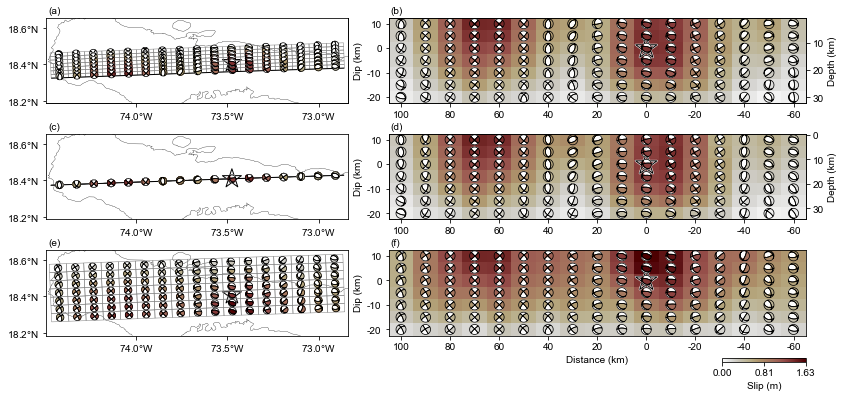

In [6]:
# slip model 
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
fig = plt.figure(figsize=figsize)

maxslipallmodeldomain = 1.628 # 1.437

for panel in [0,1,2]:
    if panel == 0:
        model = models[0]
    elif panel == 1:
        model = models[2]
    elif panel == 2:
        model = models[3]
        
    model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))
    elat, elon = model_para.lat[0], model_para.lon[0]
    ######################################################################################
    ###  map  ############################################################################
    ######################################################################################
    # basemap and bathymetry
    if panel == 0:
        axpxloc, axpyloc, axpwidth = 0.1, 0.1, 0.75
    elif panel == 1:
        axpxloc, axpyloc, axpwidth = axpA.x0, axpA.y0-axpA.height-0.075, 0.75
    elif panel == 2:
        axpxloc, axpyloc, axpwidth = axpA.x0, axpA.y0-axpA.height-0.075, 0.75
        
    tickintx, tickinty, tickformat = 0.5, 0.2, 1

    lonmin, lonmax, latmin, latmax = lonminb, lonmaxb, latminb, latmaxb = -74.494011, -72.836097, 18.184539, 18.655239
    print(lonmin, lonmax, latmin, latmax)
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,rsphere=(6378137.00,6356752.3142),resolution='h',projection='cyl')
    x, y=m([lonmin, lonmax], [latmin, latmax])
    aspect=abs(max(x)-min(x))/abs(max(y)-min(y))
    axpheight=axpwidth/aspect
    ax=fig.add_axes([axpxloc, axpyloc, axpwidth, axpheight])
    axp = axpA = ax.get_position()
    if panel == 0:
        panellabel = '(a)'
    elif panel == 1:
        panellabel = '(c)'
    elif panel == 2:
        panellabel = '(e)'
    fig.text(axp.x0+0.005, axp.y1+0.005, panellabel, va='bottom', ha='left')

    m.fillcontinents(color='w', zorder=0, alpha=0)
    m.drawcoastlines(color='k', linewidth=0.3, zorder=1)
    ax2 = utils.mapTicksBasemap(fig,m,ax,tickintx,tickinty,lonmin,lonmax,latmin,latmax,tickformat)

    # initial rupture point
    x, y = m(elon, elat)
    sc=ax.scatter(x, y, s=400, marker='*', facecolor='none', edgecolor='k', alpha=1, lw=1, zorder=1, 
                  path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

    # slip model
    cmap = cm.bilbao
    dx, dy = model_para.xx[0], model_para.yy[0]
    model_stk, model_dip = model_para.strike[0], model_para.dip[0] # <-- this is just for the visualization purpose
    nx, ny, x0, y0 = model_para.mn[0], model_para.nn[0], model_para.m0[0], model_para.n0[0]
    lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
    tmp = np.argsort(slip)
    lon = [ lon[i] for i in tmp ]
    lat = [ lat[i] for i in tmp ]
    slip = [ slip[i] for i in tmp ]
    dep = [ dep[i] for i in tmp ]
    for i in range(len(lat)):
        xslipcell, yslipcell = utils.getSlipCell(lat[i], lon[i], dx, dy, model_stk, model_dip, m)
        ax.fill(xslipcell, yslipcell, facecolor='none', zorder=1, edgecolor='gray', lw=0.5)

    if model_para.dip[0] > 0:
        utils.plotModelTop(dx, dy, nx, ny, x0, y0, model_dip, model_stk, elat, elon, m, ax, 10)    

    data = np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'FFM_DCall.txt'), skiprows=1)
    lon,lat,dep,slip = data[:,1],data[:,2],data[:,3],data[:,4]
    strike0,dip0,rake0,strike1,dip1,rake1 = data[:,5],data[:,6],data[:,7],data[:,8],data[:,9],data[:,10]
    xloc,yloc = data[:,11],data[:,12]

    data=np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'FFM_MT.txt'))
    m1,m2,m3,m4,m5,m6 = data[:,4],data[:,5],data[:,6],data[:,7],data[:,8],data[:,9]

    x, y = m(lon, lat)
    for i in range(len(slip)):
        focmec = [m1[i],m2[i],m3[i],m4[i],m5[i],m6[i]]
        focmec = utils.convertUSEtoNED(focmec)
        tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*0.75, position=(x[i], y[i]),
                                 beachball_type='deviatoric', edgecolor='none', color_t=cmap(slip[i]/maxslipallmodeldomain),
                                 color_p='w', linewidth=0.75, alpha=1, zorder=11+int(slip[i]/maxslipallmodeldomain*100), view='top')
        tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*0.75, position=(x[i], y[i]),
                                 beachball_type='dc', edgecolor='k', color_t='none',
                                 color_p='none', linewidth=0.75, alpha=1, zorder=11+int(slip[i]/maxslipallmodeldomain*100), view='top')

    print(max(slip))


    ######################################################################################
    ###  cross section  ##################################################################
    ######################################################################################
    #axw = 1
    aspect = (model_para.xx[0] * model_para.mn[0])/(model_para.yy[0] * model_para.nn[0])
    #axh = axw / aspect
    axh = axp.height
    axw = axh * aspect

    axx0, axy0 = axp.x1+0.1, axp.y0
    ax = fig.add_axes([axx0, axy0, axw, axh])
    axp = ax.get_position()
    if panel == 0:
        panellabel = '(b)'
    elif panel == 1:
        panellabel = '(d)'
    elif panel == 2:
        panellabel = '(f)'
    fig.text(axp.x0+0.005, axp.y1+0.005, panellabel, va='bottom', ha='left')

    data = np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'FFM_DCall.txt'), skiprows=1)
    lon,lat,dep,slip = data[:,1],data[:,2],data[:,3],data[:,4]
    strike0,dip0,rake0,strike1,dip1,rake1 = data[:,5],data[:,6],data[:,7],data[:,8],data[:,9],data[:,10]
    xloc,yloc = data[:,11],data[:,12]

    data=np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'FFM_MT.txt'))
    m1,m2,m3,m4,m5,m6 = data[:,4],data[:,5],data[:,6],data[:,7],data[:,8],data[:,9]



    strike, dip, rake = [],[],[]
    for i in range(len(strike0)):
        #tmpstr, tmpdip, tmprake = myutils.selectplane(model_para.strike[0],model_para.dip[0],strike0[i],dip0[i],rake0[i],strike1[i],dip1[i],rake1[i])
        tmpstr, tmpdip, tmprake = utils.selectplane(model_para.strike[0],90,strike0[i],dip0[i],rake0[i],strike1[i],dip1[i],rake1[i])
        strike.append(tmpstr)
        dip.append(tmpdip)
        rake.append(tmprake)

    dx, dy = model_para.xx[0], model_para.yy[0]
    xmin, xmax = np.min(xloc)-dx/2, np.max(xloc)+dx/2
    ymin, ymax = np.min(yloc)-dy/2, np.max(yloc)+dy/2
    cmap = cm.bilbao

    for i in np.arange(len(slip)):
        tmpx, tmpy = xloc[i], yloc[i]
        tmpxlist = [tmpx-dx/2, tmpx+dx/2, tmpx+dx/2, tmpx-dx/2, tmpx-dx/2]
        tmpylist = [tmpy-dy/2, tmpy-dy/2, tmpy+dy/2, tmpy+dy/2, tmpy-dy/2]
        ax.fill(tmpxlist, tmpylist, facecolor=cmap(slip[i]/maxslipallmodeldomain), edgecolor='none', zorder=0)


    ax.scatter(0, 0, marker='*', s=500, facecolor='none', edgecolor='k', 
               path_effects = [path_effects.Stroke(linewidth=2, foreground='w'), path_effects.Normal()])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('Dip (km)')

    if model_para.dip[0] > 0:
        ax2 = ax.twinx()
        depmin = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymin
        depmax = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*ymax
        ax2.set_ylim(depmin, depmax)
        ax2.set_ylabel('Depth (km)')


    arrowflag = 'beach'

    x, y = xloc, yloc
    #y = model_para.depth[0]-np.sin(np.deg2rad(model_para.dip[0]))*y

    for i in range(len(slip)):
        if arrowflag == 'rake':
            a=np.deg2rad(rake[i]+180)
            length=slip[i] / max(slip) * dx * 0.5
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            ax2.plot([x[i], x1+x[i]], [y[i], y1+y[i]], color='C2', lw=1, solid_capstyle='round', clip_on=False, zorder=100)
            x2, y2 =np.cos(a-np.deg2rad(150))*length*0.2, np.sin(a-np.deg2rad(150))*length*0.2
            ax2.plot([x1+x[i], x1+x2+x[i]], [y1+y[i], y1+y2+y[i]], color='C2', lw=1, solid_capstyle='round', clip_on=False, zorder=100)
            x2, y2 =np.cos(a+np.deg2rad(150))*length*0.2, np.sin(a+np.deg2rad(150))*length*0.2
            ax2.plot([x1+x[i], x1+x2+x[i]], [y1+y[i], y1+y2+y[i]], color='C2', lw=1, solid_capstyle='round', clip_on=False, zorder=100)

        elif arrowflag == 'strike':
            a=np.deg2rad(-strike[i]+90+180)

            length=slip[i] / max(slip) * dx
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            ax2.plot([x[i]-x1, x1+x[i]], [y[i]-y1, y1+y[i]], color='C2', lw=1, solid_capstyle='round', clip_on=False)            

        elif arrowflag == 'dip':
            a=np.deg2rad(dip[i]-180)
            length=slip[i] / max(slip) * dy
            x1=np.cos(a)*length
            y1=np.sin(a)*length
            ax.plot([x[i]-x1, x1+x[i]], [y[i]-y1, y1+y[i]], color='C2', lw=1, solid_capstyle='round', clip_on=False)

        elif arrowflag == 'beach':
            focmec = [m1[i],m2[i],m3[i],m4[i],m5[i],m6[i]]
            focmec = utils.convertUSEtoNED(focmec)
            tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*1, position=(x[i], y[i]),
                                     beachball_type='deviatoric', edgecolor='none', color_t=cmap(slip[i]/maxslipallmodeldomain),
                                     color_p='w', linewidth=0.75, alpha=1, zorder=1, view='top')
            tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*1, position=(x[i], y[i]),
                                     beachball_type='dc', edgecolor='k', color_t='none',
                                     color_p='none', linewidth=0.75, alpha=1, zorder=1, view='top')


    ax.invert_xaxis()

    

ax.set_xlabel('Distance (km)')
    
axp = ax.get_position()
cax=fig.add_axes([axp.x1-axp.width/5, axp.y0-0.065, axp.width/5, 0.01])
norm=mpl.colors.Normalize(vmin=0, vmax=maxslipallmodeldomain)
cb=mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, label='Slip (m)', 
                             ticks=np.linspace(0, maxslipallmodeldomain, 3), format='%.2f', orientation='horizontal')
    
plt.savefig(figdir+'/modeldomain.png', bbox_inches='tight', pad_inches=0.1, dpi=150, facecolor='w')
plt.show()

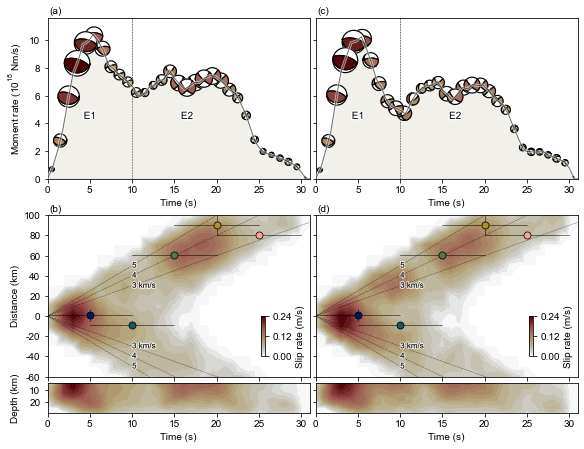

In [7]:
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)

fig=plt.figure(figsize=figsize)

for model in [models[0], models[1]]:

    model_para = utils.load_fort40(os.path.join('../materials/ffm/model_'+model, 'fort.40'))

    if model == '210822074516':
        ax = fig.add_axes([0.1, 0.1, 0.65, 0.4])
        axpA = ax.get_position()
        axp = ax.get_position()
        fig.text(axp.x0+0.005, axp.y1+0.005, '(a)', va='bottom', ha='left')
    else:
        ax = fig.add_axes([axpA.x1+0.015, axpA.y0, axpA.width, axpA.height])
        axp = ax.get_position()
        fig.text(axp.x0+0.005, axp.y1+0.005, '(c)', va='bottom', ha='left')

    cmap = cm.bilbao

    data=np.loadtxt('../materials/ffm/model_'+model+'/st_'+model+'.dat')
    t, amp=data[:,0], data[:,1]
    vr = model_para['vr'][0]
    ax.plot(t, amp, color='k', label='Vr '+str(vr)+' km/s', lw=1, zorder=1001, alpha=0.55, 
            path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=0.55), path_effects.Normal()])
    ax.fill(t, amp, color=cmap(0.3), alpha=0.2)


    maxsliprateall = np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'snap_1sec_meca_201.txt'), usecols=8, skiprows=1)[0]
    maxsliprateall = 0.244736
    data = np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'tw_mec.dat'))
    snap_t, str_total, dip_total, rake_total = data[:,0], data[:,9], data[:,11], data[:,13]
    m1, m2, m3, m4, m5, m6 = data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]
    dx, dy = model_para.xx[0], model_para.yy[0]

    for snap in range(0, 31, 1):
        data=np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'snap_1sec_meca_'+str(200+snap+1)+'.txt'), skiprows=1)
        xloc, yloc, dep, avesliprate, maxsliprate=data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
        slip = avesliprate
        focmec=[str_total[snap], dip_total[snap], rake_total[snap]]
        color=cmap(np.max(slip)/maxsliprateall)
        tmp = beachball.plot_beachball_mpl(focmec, ax, size=dx*np.max(slip)/maxsliprateall*0.85*3, position=(t[np.where(t==snap+0.5)], amp[np.where(t==snap+0.5)]),
                                 beachball_type='dc', edgecolor='k', color_t=color,
                                 color_p='w', linewidth=1.2, alpha=1, zorder=int(np.max(slip)/maxsliprateall*100))
        tmp.set_clip_on(False)

    ax.axvline(10, linestyle='--', lw=0.5, color='k', zorder=0)
    ax.text(5, 4.5, 'E1', ha='center', va='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=1), path_effects.Normal()])
    ax.text(16.5, 4.5, 'E2', ha='center', va='center',path_effects=[path_effects.Stroke(linewidth=3, foreground='w', alpha=1), path_effects.Normal()])

    ax.set_xlim(0, snap+1)
    ax.set_ylim(0, 11.6)

    ax.set_xlabel('Time (s)')

    if model == '210822074516':
        ax.set_ylabel('Moment rate '+r'($10^{18}$ Nm/s)')
    else:
        ax.set(yticklabels=[])
    

    axp = ax.get_position()
    ax = utils.plotTimeEvo(fig, model, axp.x0, axp.y0-0.49, 0.65, 0.4)
    ax.set_xlim(0, snap+1)
    ax.set_xticklabels([])

    # snapshot
    peaklon, peaklat = np.loadtxt('../materials/bp/bppeakloci.txt', unpack=True, usecols=(0,1))
    data = np.loadtxt('../materials/bp/jackknife.txt')
    ja_dis, ja_lat, ja_lon = data[:,0], data[:,1], data[:,2]

    winnum1 = 5
    colors = cm.batlow(np.linspace(0,1,winnum1+1))

    Fs = 100
    ts = 5
    t1 = 10

    iwinstep = ts*Fs
    iwinlen = t1*Fs
    for i in range(winnum1):

        wstp = i * iwinstep
        wedp = wstp + iwinlen
        centertime = wstp/Fs+(wedp/Fs-wstp/Fs)/2

        tmpdis, tmpdis_ref, proj_theta = utils.project_on_ref_fault(model_para.lat[0], model_para.lon[0], peaklat[i], peaklon[i], model_para.strike[0])

        alpha=1
        ax.scatter(centertime, tmpdis_ref, facecolor=colors[i], edgecolor='k', linewidth=0.75, zorder=2, s=50, alpha=alpha)
        ax.plot([centertime-t1/2, centertime+t1/2], [tmpdis_ref, tmpdis_ref], linewidth=0.5, color='k', zorder=1, alpha=alpha)

        proj_ja_dis = ja_dis[i] * np.cos(np.deg2rad(proj_theta))
        ax.plot([centertime, centertime], [tmpdis_ref+proj_ja_dis, tmpdis_ref-proj_ja_dis], linewidth=0.5, color='k', zorder=1, alpha=alpha)

    if model == '210922064542':
        ax.set(yticklabels=[], ylabel='')
        
        
        
    scale = (max(yloc)-min(yloc))/(max(xloc)-min(xloc))
    axp = ax.get_position()
    ax = utils.plotTimeEvoDip(fig, model, axp.x0, axp.y0-axp.height*scale-0.015, axp.width, axp.height*scale)
    ax.set_xlim(0, snap+1)
    
    if model == '210822074516':
        fig.text(axp.x0+0.005, axp.y1+0.005, '(b)', va='bottom', ha='left')
    else:
        fig.text(axp.x0+0.005, axp.y1+0.005, '(d)', va='bottom', ha='left')
        ax.set(ylabel='', yticklabels=[])

plt.savefig(figdir+'/evo_synthetic.png', bbox_inches='tight', pad_inches=0.1, dpi=150)
plt.show()

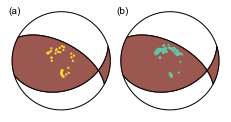

In [6]:
BP = io.loadmat('../materials/bp/Haiti_EV1_BP1.mat')
AL = io.loadmat('../materials/bp/Haiti_EV1_AL1_2.mat')
station_loc_all = BP['SEIS']['STLOCS'][0][0]

cccut = 0.6
BDLIST = np.hstack(AL['AL'][0][0]['BDLIST'][0][0])
GDlist0 = (1-BDLIST).ravel().nonzero()
RAVG = np.hstack(AL['AL'][0][0]['RAVG'][0][0])
tmpidx = RAVG.ravel().nonzero()
tmpidx = np.where(RAVG[tmpidx]>cccut)
GDlist = np.intersect1d(GDlist0, tmpidx)
station_loc = BP['SEIS']['STLOCS'][0][0][GDlist]


import numpy as num
from matplotlib import pyplot as plt
from pyrocko import moment_tensor as pmt, cake, orthodrome
from pyrocko.plot import beachball

km = 1000.


models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm', 'model_'+model, 'fort.40'))
elat, elon = model_para.lat[0], model_para.lon[0]

# source position and mechanism
slat, slon, sdepth = elat, elon, 12.*km

data = np.loadtxt(os.path.join('../materials/ffm', 'model_'+model, 'tw_mec.dat'))
snap_t, str_total, dip_total, rake_total = data[:,0], data[:,9], data[:,11], data[:,13]
m1, m2, m3, m4, m5, m6 = data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], data[:,8]

snap = 0
focmec = focmec=[m1[snap], m2[snap], m3[snap], m4[snap], m5[snap], m6[snap]]
focmec = utils.convertUSEtoNED(focmec)
mt = pmt.MomentTensor.from_values(focmec)
#mt = pmt.MomentTensor.from_values([266, 64, 43])


# receiver positions
rdepth = 0.0
data = np.loadtxt('../materials/ffm/model_'+model+'/station_'+model+'.list', usecols=(2,3))
rlons, rlats = data[:,1], data[:,0] # inversion
#rlons, rlats = station_loc[:,1], station_loc[:,0] # BP

# earth model and phase for takeoff angle computations
mod = cake.load_model('ak135-f-continental.m')
phases = cake.PhaseDef.classic('P')

cmap = cm.bilbao


# setup figure with aspect=1.0/1.0, ranges=[-1.1, 1.1]
fig = plt.figure(figsize=(2., 2.))  # size in inch
#fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
#axes = fig.add_subplot(1, 1, 1, aspect=1.0)

for panel in [0,1]:
    if panel == 0:
        axes = fig.add_axes([0.1, 0.1, 0.75, 0.75])
        axp = axes.get_position()        
        fig.text(axp.x0+0.005, axp.y1, '(a)', va='top', ha='left')
        rlons, rlats = data[:,1], data[:,0] # inversion
        
    else:
        axp = axes.get_position()
        axes = fig.add_axes([axp.x1+0.005, axp.y0, axp.width, axp.height])
        axp = axes.get_position()        
        fig.text(axp.x0+0.005, axp.y1, '(b)', va='top', ha='left')
        rlons, rlats = station_loc[:,1], station_loc[:,0] # BP
        


    axes.set_axis_off()
    axes.set_xlim(-1.1, 1.1)
    axes.set_ylim(-1.1, 1.1)

    projection = 'lambert'

    beachball.plot_beachball_mpl(
        mt, axes,
        position=(0., 0.),
        size=2.0,
        color_t=cmap(0.7),
        projection=projection,
        edgecolor='k',
        linewidth=1,
        size_units='data', 
        beachball_type='dc')


    for rlat, rlon in zip(rlats, rlons):
        distance = orthodrome.distance_accurate50m(slat, slon, rlat, rlon)
        rays = mod.arrivals(
            phases=cake.PhaseDef('P'),
            zstart=sdepth, zstop=rdepth, distances=[distance*cake.m2d])

        if not rays:
            continue

        takeoff = rays[0].takeoff_angle()
        azi = orthodrome.azimuth(slat, slon, rlat, rlon)

        # to spherical coordinates, r, theta, phi in radians
        rtp = num.array([[1., num.deg2rad(takeoff), num.deg2rad(90.-azi)]])

        # to 3D coordinates (x, y, z)
        points = beachball.numpy_rtp2xyz(rtp)

        # project to 2D with same projection as used in beachball
        x, y = beachball.project(points, projection=projection).T

        if panel == 1:
            facecolor='C0'
        else:
            facecolor='C5'
        axes.scatter(x, y, edgecolor='none', facecolor=facecolor, s=5, lw=0.5)

plt.savefig(os.path.join(figdir, 'pol.pdf'), bbox_inches='tight', pad_inches=0.1, dpi=300, facecolor='w')
plt.show()

18.323587280499392 -73.24899630386847 0.78971696532 40.0 30.0 0.0 40.0 -30.0 0.0 278.427 62.74 0.30618285149 1.33226914002 0.0 0.0 0.0 0.0
18.323587280499392 -73.24899630386847 0.78971696532 40.0 30.0 0.0 40.0 -30.0 0.0 278.427 62.74 0.30618285149 1.33226914002 0.0 0.0 0.0 0.0


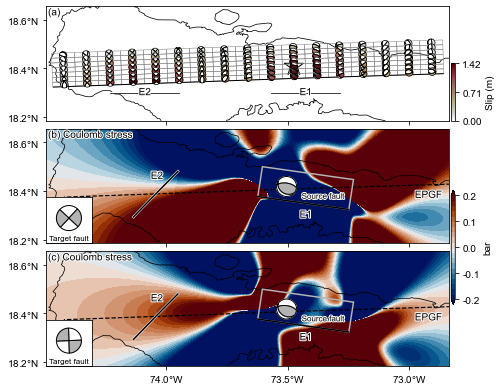

In [2]:
# slip model 
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm/model_'+model, 'fort.40'))
elat, elon = model_para.lat[0], model_para.lon[0]
fig = plt.figure(figsize=figsize)

data223 = '../materials/coulomb/coulomb_223_10km.out'
data268 = '../materials/coulomb/coulomb_268_10km.out'

panellabel = 'Coulomb stress'
figname = figdir+'/coulomb_10km_mu0.4.png'


for panel in [0,1,2]:
    if panel == 0:
        axpxloc, axpyloc, axpwidth = 0.1, 0.1, 1
    else:
        axp = ax.get_position()
        axpxloc, axpyloc, axpwidth = axp.x0, axp.y0-axp.height-0.02, axp.width

    tickintx, tickinty, tickformat = 0.5, 0.2, 1
    lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
    lonmin, lonmax, latmin, latmax = lonminb, lonmaxb, latminb, latmaxb = min(lon)-0.07, max(lon)+0.07, min(lat)-0.15, max(lat)+0.15
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,rsphere=(6378137.00,6356752.3142),resolution='h',projection='cyl')
    x, y=m([lonmin, lonmax], [latmin, latmax])
    aspect=abs(max(x)-min(x))/abs(max(y)-min(y))
    axpheight=axpwidth/aspect
    ax=fig.add_axes([axpxloc, axpyloc, axpwidth, axpheight])
    m.fillcontinents(color='w', zorder=0, alpha=0)
    m.drawcoastlines(color='k', linewidth=0.75, zorder=1)
    ax2 = utils.mapTicksBasemap(fig,m,ax,tickintx,tickinty,lonmin,lonmax,latmin,latmax,tickformat)
    
    
    axp = ax.get_position()
    
    if panel == 0:
        text = '(a)'
    elif panel == 1:
        text = '(b) '+panellabel
    elif panel == 2:
        text = '(c) '+panellabel
    fig.text(axp.x0+0.005, axp.y1-0.005, text, va='top', ha='left',
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
    

    if panel == 0:    
        # initial rupture point
        x, y = m(elon, elat)
        sc=ax.scatter(x, y, s=400, marker='*', facecolor='none', edgecolor='k', alpha=1, lw=1, zorder=1, 
                      path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

        # draw beachball
        utils.drawslipbeachball(ax, m, model, model_para, elat, elon, 1, fig)
        
        # episode labels
        lat0 = 18.3
        e1lon0, e1lon1 = -73.568123, -73.284416
        e2lon0, e2lon1 = -74.229958, -73.946327
        for lon0, lon1, label in zip([e1lon0,e2lon0], [e1lon1,e2lon1], ['E1', 'E2']):
            ax.plot([lon0, lon1], [lat0, lat0], color='k', lw=0.75,
                    path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
            ax.text(lon0+(lon1-lon0)/2, 18.3, label, va='center', ha='center',
                    path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
        

    if panel >= 1:
        data = np.loadtxt(os.path.join('../materials/ffm/model_'+model, 'FFM_DCall.txt'), skiprows=1)
        lon,lat,dep,slip = data[:,1],data[:,2],data[:,3],data[:,4]
        strike0,dip0,rake0,strike1,dip1,rake1 = data[:,5],data[:,6],data[:,7],data[:,8],data[:,9],data[:,10]
        #for i in range(len(slip)):
        #    if slip[i] >= max(slip)*0.95:
        #        print(lon[i],lat[i],dep[i],slip[i], strike0[i],dip0[i],rake0[i],strike1[i],dip1[i],rake1[i])
                #ax.scatter(lon[i], lat[i], zorder=2000)

        # peak slip of E1
        # -73.474281 18.38821 7.50603 1.367 125.073 29.963 113.495 278.427 62.74 77.057

        # reference fault geometry
        ref_strike = 278.427
        ref_dip = 62.74
        ref_rake = 77.057

        tmp = beachball.plot_beachball_mpl([ref_strike, ref_dip, ref_rake], ax, size=20, position=(elon-0.03, elat+0.01),
                                 beachball_type='dc', edgecolor='k', color_t='C7',
                                 color_p='w', linewidth=1, alpha=1, zorder=1000, view='top')

        ax.text(elon+0.12, elat-0.02, 'Source fault', va='top', ha='center', size=8, 
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])


        tmp = geod.Direct(elat, elon, ref_strike-90, 12.5*np.cos(np.deg2rad(ref_dip))*1e3)
        toplat, toplon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(toplat, toplon, ref_strike, 15*1e3)
        RTlat, RTlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(toplat, toplon, ref_strike-180, 25*1e3)
        LTlat, LTlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(elat, elon, ref_strike+90, 17.5*np.cos(np.deg2rad(ref_dip))*1e3)
        bottomlat, bottomlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(bottomlat, bottomlon, ref_strike, 15*1e3)
        RBlat, RBlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(bottomlat, bottomlon, ref_strike-180, 25*1e3)
        LBlat, LBlon = tmp['lat2'], tmp['lon2']

        ax.plot([LTlon, LBlon, RBlon, RTlon, LTlon], [LTlat, LBlat, RBlat, RTlat, LTlat], zorder=3000, solid_joinstyle='miter', color='C7')
        ax.plot([LTlon, RTlon], [LTlat, RTlat], zorder=3000, color='k')

        # reference fault point (left top)
        LTdep = 3.01206 - 2.5 * np.sin(np.deg2rad(ref_dip))

        # reference slip 
        # 1.367
        ss_slip = 1.367 * np.cos(np.deg2rad(ref_rake))
        dip_slip = 1.367 * np.sin(np.deg2rad(ref_rake))

        # input line for `synthetic_1slipmodel.in`
        print(LTlat, LTlon, LTdep, 40.0, 30.0, 0.0, 40.0, -30.0, 0.0, ref_strike, ref_dip, ss_slip, dip_slip, 0.0, 0.0, 0.0, 0.0)


        if panel == 1:
            data = np.loadtxt(data223, skiprows=1)
        elif panel == 2:
            data = np.loadtxt(data268, skiprows=1)
            
        if panellabel == 'Shear stress':
            x, y, amp = data[:,0], data[:,1], data[:,2] # shear
        elif panellabel == 'Normal stress':
            x, y, amp = data[:,0], data[:,1], data[:,3] # normal
        elif panellabel == 'Coulomb stress':
            x, y, amp = data[:,0], data[:,1], data[:,4] # coulomb
        
        vmin, vmax = -0.2, 0.2

        xs=np.linspace(min(x), max(x), 1000)
        ys=np.linspace(min(y), max(y), 1000)
        X, Y = np.meshgrid(xs, ys)
        Z = griddata((x, y), amp, (X, Y),'linear')
        levels = np.linspace(vmin, vmax, 21)
        cmap = cm.vik
        sc = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, extend='both', zorder=0)

        
        if panel == 1:
            target_strike = 223
            axp = ax.get_position()
            cax = fig.add_axes([axp.x1+0.005, axp.y0-axp.height/2-0.01, 0.01, axp.height])
            plt.colorbar(sc, cax=cax, label='bar', ticks=np.arange(vmin, vmax+0.1, 0.1))
        elif panel == 2:
            target_strike = 268
            
        axp = ax.get_position()
        axb = fig.add_axes([axp.x0, axp.y0, axp.height*0.4, axp.height*0.4])
        tmp = beachball.plot_beachball_mpl([target_strike, 90, 0], axb, size=25, position=(0.5, 0.55),
                                 beachball_type='dc', edgecolor='k', color_t='C7',
                                 color_p='w', linewidth=1, alpha=1, zorder=1000, view='top')
        
        axb.set(xticks=[], yticks=[])
        axbp = axb.get_position()
        fig.text(axbp.x0+axbp.width/2, axbp.y0+0.005, 'Target fault', va='bottom', ha='center', size=8)
        
        data = np.loadtxt('../materials/ffm/interpolated_lat_lon_str_223.dat', comments='>')
        ind = data[:,1].argsort()
        data = data[ind]
        ind = np.where((data[:,2] == 3.0121) & (data[:,1] >= -74.234818+0.1) & (data[:,1] <= -73.950996) )
        data = data[ind]
        ax.plot(data[:,1], data[:,0]+0.8, color='k', zorder=2000,
                         path_effects=[path_effects.Stroke(linewidth=2.5, foreground='w', alpha=1), path_effects.Normal()])
        
        sf = shapefile.Reader('../materials/work/gem-global-active-faults/shapefile/gem_active_faults.shp', encoding='ISO8859-1')
        fields = sf.fields[1:] 
        field_names = [field[0] for field in fields] 
        for r in sf.shapeRecords():  
            atr = dict(zip(field_names, r.record))
            if atr['catalog_na'] == 'GEM_Central_Am_Carib':# or 'Bird 2003':
                x = [i[0] for i in r.shape.points[:]]
                y = [i[1] for i in r.shape.points[:]]
                x, y = m(x, y)
                #if atr['slip_type'] == 'Reverse':
                #rev = ax.plot(x, y, color='k', lw=1.2, zorder=2, alpha=1, linestyle='--', 
                #             path_effects=[path_effects.Stroke(linewidth=2.5, foreground='w', alpha=1), path_effects.Normal()])
                
        for dis in [-100, 100]:
            tmp = geod.Direct(elat, elon, 268, dis*1e3)
            x0, y0 = m(tmp['lon1'], tmp['lat1'])
            x1, y1 = m(tmp['lon2'], tmp['lat2'])
            rev = ax.plot([x0,x1], [y0,y1], color='k', lw=1.2, zorder=2, alpha=1, linestyle='--')
            
        # episode labels
        e1lon0, e1lon1 = -73.568123, -73.284416
        e2lon0, e2lon1 = -74.229958+0.05, -73.946327+0.05
        for lon0, lon1, lat0, label in zip([e1lon0,e2lon0], [e1lon1,e2lon1], [18.3, 18.46], ['E1', 'E2']):
            ax.text(lon0+(lon1-lon0)/2, lat0, label, va='center', ha='center',
                    path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
            
            
        ax.text(lonmax-0.03, 18.4, 'EPGF', va='top', ha='right',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
            
        
            
    if panel <= 1:
        ax2.set_xticklabels([])


plt.savefig(figname, bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

-74.494011 -71.906097 18.184539 18.655239
-74.494011 -71.906097 18.184539 18.655239


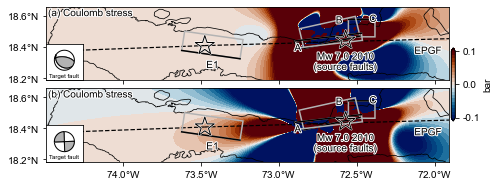

In [2]:
def drawsourcefault(reflat, reflon, refstr, refdip, leftlen, rightlen, width):
    tmp = geod.Direct(reflat, reflon, refstr+180, leftlen*1e3)
    LTlat, LTlon = tmp['lat2'], tmp['lon2']

    tmp = geod.Direct(reflat, reflon, refstr, rightlen*1e3)
    RTlat, RTlon = tmp['lat2'], tmp['lon2']

    tmp = geod.Direct(LTlat, LTlon, refstr+90, width*np.cos(np.deg2rad(refdip))*1e3)
    LBlat, LBlon = tmp['lat2'], tmp['lon2']

    tmp = geod.Direct(RTlat, RTlon, refstr+90, width*np.cos(np.deg2rad(refdip))*1e3)
    RBlat, RBlon = tmp['lat2'], tmp['lon2']

    ax.plot([LTlon, LBlon, RBlon, RTlon, LTlon], [LTlat, LBlat, RBlat, RTlat, LTlat], zorder=3000, solid_joinstyle='miter', color='C7')
    ax.plot([LTlon, RTlon], [LTlat, RTlat], zorder=3000, color='k')
    
    

# slip model 
models = (np.loadtxt('../materials/ffm/modellist.txt', usecols=0, dtype=int)).astype(str)
model = models[0]
model_para = utils.load_fort40(os.path.join('../materials/ffm/model_'+model, 'fort.40'))
elat, elon = model_para.lat[0], model_para.lon[0]
fig = plt.figure(figsize=figsize)

data268 = '../materials/coulomb/2010_coulomb_268_12km_mu0.4.out'
data278 = '../materials/coulomb/2010_coulomb_278_12km_mu0.4.out'

panellabel = 'Coulomb stress'
figname = figdir+'/2010_coulomb_12km_mu0.4.png'


for panel in [0,1]:
    if panel == 0:
        axpxloc, axpyloc, axpwidth = 0.1, 0.1, 1
    else:
        axp = ax.get_position()
        axpxloc, axpyloc, axpwidth = axp.x0, axp.y0-axp.height-0.02, axp.width

    tickintx, tickinty, tickformat = 0.5, 0.2, 1
    lon, lat, dep, slip = np.loadtxt('../materials/ffm/model_'+model+'/FFM_DCall.txt', unpack=True, usecols=(1,2,3,4), skiprows=1)
    lonmin, lonmax, latmin, latmax = lonminb, lonmaxb, latminb, latmaxb = min(lon)-0.07, max(lon)+1, min(lat)-0.15, max(lat)+0.15
    m=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,urcrnrlon=lonmax,urcrnrlat=latmax,rsphere=(6378137.00,6356752.3142),resolution='h',projection='cyl')
    x, y=m([lonmin, lonmax], [latmin, latmax])
    aspect=abs(max(x)-min(x))/abs(max(y)-min(y))
    axpheight=axpwidth/aspect
    ax=fig.add_axes([axpxloc, axpyloc, axpwidth, axpheight])
    m.fillcontinents(color='w', zorder=0, alpha=0)
    m.drawcoastlines(color='k', linewidth=0.75, zorder=1)
    ax2 = utils.mapTicksBasemap(fig,m,ax,tickintx,tickinty,lonmin,lonmax,latmin,latmax,tickformat)
    
    print(lonmin, lonmax, latmin, latmax)
    
    axp = ax.get_position()
    
    if panel == 0:
        text = '(a) '+panellabel
    elif panel == 1:
        text = '(b) '+panellabel
    elif panel == 2:
        text = '(c) '+panellabel
    fig.text(axp.x0+0.005, axp.y1-0.005, text, va='top', ha='left',
             path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
    

    if panel >= 0:    
        # initial rupture point
        x, y = m(elon, elat)
        sc=ax.scatter(x, y, s=400, marker='*', facecolor='none', edgecolor='k', alpha=1, lw=1, zorder=5000, 
                      path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
        # 2010 epicenter USGS
        x, y = m(-72.571, 18.443)
        sc=ax.scatter(x, y, s=400*(7/7.2), marker='*', facecolor='none', edgecolor='k', alpha=1, lw=1, zorder=5000, 
                      path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        ax.text(-72.571, 18.443-0.08, 'Mw 7.0 2010\n(source faults)', va='top', ha='center',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
        

        # 2010 Hayes Nat Geo slip model
        reflat, reflon, refstr, refdip, leftlen, rightlen, width = 18.5760, -72.5391, 90, 45, 1.5, 16.5, 17.5
        drawsourcefault(reflat, reflon, refstr, refdip, leftlen, rightlen, width)
        ax.text(reflon+0.12, reflat, 'C', ha='left', va='center', zorder=5000,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

        reflat, reflon, refstr, refdip, leftlen, rightlen, width = 18.4660, -72.4929, 257, 55, 1.5, 37.5, 25
        drawsourcefault(reflat, reflon, refstr, refdip, leftlen, rightlen, width)
        ax.text(reflon-0.12, reflat+0.1, 'B', ha='center', va='center', zorder=5000,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

        reflat, reflon, refstr, refdip, leftlen, rightlen, width = 18.4399, -72.8784, 83, 70, 1.5, 43.5, 15
        drawsourcefault(reflat, reflon, refstr, refdip, leftlen, rightlen, width)
        ax.text(reflon, reflat-0.05, 'A', ha='center', va='center', zorder=5000,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
        if panel == 0:
            data = np.loadtxt(data278, skiprows=1)
        elif panel == 1:
            data = np.loadtxt(data268, skiprows=1)
            
        if panellabel == 'Shear stress':
            x, y, amp = data[:,0], data[:,1], data[:,2] # shear
        elif panellabel == 'Normal stress':
            x, y, amp = data[:,0], data[:,1], data[:,3] # normal
        elif panellabel == 'Coulomb stress':
            x, y, amp = data[:,0], data[:,1], data[:,4] # coulomb

        vmin, vmax = -0.1, 0.1

        xs=np.linspace(min(x), max(x), 1000)
        ys=np.linspace(min(y), max(y), 1000)
        X, Y = np.meshgrid(xs, ys)
        Z = griddata((x, y), amp, (X, Y),'linear')
        levels = np.linspace(vmin, vmax, 21)
        cmap = cm.vik
        sc = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax, extend='both', zorder=0)
        
        
        
        sf = shapefile.Reader('../materials/work/gem-global-active-faults/shapefile/gem_active_faults.shp', encoding='ISO8859-1')
        fields = sf.fields[1:] 
        field_names = [field[0] for field in fields] 
        for r in sf.shapeRecords():  
            atr = dict(zip(field_names, r.record))
            if atr['catalog_na'] == 'GEM_Central_Am_Carib':# or 'Bird 2003':
                x = [i[0] for i in r.shape.points[:]]
                y = [i[1] for i in r.shape.points[:]]
                x, y = m(x, y)
                #if atr['slip_type'] == 'Reverse':
                #rev = ax.plot(x, y, color='k', lw=1.2, zorder=2, alpha=1, linestyle='--')
                
        for dis in [-200, 150]:
            tmp = geod.Direct(elat, elon, 268, dis*1e3)
            x0, y0 = m(tmp['lon1'], tmp['lat1'])
            x1, y1 = m(tmp['lon2'], tmp['lat2'])
            rev = ax.plot([x0,x1], [y0,y1], color='k', lw=1.2, zorder=2, alpha=1, linestyle='--')
        
                
        # receiver fault geometry
        ref_strike = 278.427
        ref_dip = 62.74
        ref_rake = 77.057

        tmp = geod.Direct(elat, elon, ref_strike-90, 12.5*np.cos(np.deg2rad(ref_dip))*1e3)
        toplat, toplon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(toplat, toplon, ref_strike, 15*1e3)
        RTlat, RTlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(toplat, toplon, ref_strike-180, 25*1e3)
        LTlat, LTlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(elat, elon, ref_strike+90, 17.5*np.cos(np.deg2rad(ref_dip))*1e3)
        bottomlat, bottomlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(bottomlat, bottomlon, ref_strike, 15*1e3)
        RBlat, RBlon = tmp['lat2'], tmp['lon2']

        tmp = geod.Direct(bottomlat, bottomlon, ref_strike-180, 25*1e3)
        LBlat, LBlon = tmp['lat2'], tmp['lon2']

        ax.plot([LTlon, LBlon, RBlon, RTlon, LTlon], [LTlat, LBlat, RBlat, RTlat, LTlat], zorder=3000, solid_joinstyle='miter', color='C7')
        ax.plot([LTlon, RTlon], [LTlat, RTlat], zorder=3000, color='k')
        
        
        # episode labels
        e1lon0, e1lon1 = -73.568123, -73.284416
        e2lon0, e2lon1 = -74.229958+0.05, -73.946327+0.05
        for lon0, lon1, lat0, label in zip([e1lon0], [e1lon1], [18.28], ['E1']):
            ax.text(lon0+(lon1-lon0)/2, lat0, label, va='center', ha='center',
                    path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])
        
        
        ax.text(lonmax-0.05, 18.4, 'EPGF', va='top', ha='right',
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w', alpha=1), path_effects.Normal()])

        # draw beachball
        #utils.drawslipbeachball(ax, m, model, model_para, elat, elon, 1, fig)
        
        
        if panel == 0:
            target_strike = 278.4
            target_dip = 62.7
            target_rake = 77.1
            
            axp = ax.get_position()
            cax = fig.add_axes([axp.x1+0.005, axp.y0-axp.height/2-0.01, 0.01, axp.height])
            plt.colorbar(sc, cax=cax, label='bar', ticks=np.arange(vmin, vmax+2, 2))
            plt.colorbar(sc, cax=cax, label='bar', ticks=np.arange(vmin, vmax+0.1, 0.1))
        elif panel == 1:
            target_strike = 268
            target_dip = 90
            target_rake = 0
            
        axp = ax.get_position()
        axb = fig.add_axes([axp.x0, axp.y0, axp.height*0.5, axp.height*0.5])
        tmp = beachball.plot_beachball_mpl([target_strike, target_dip, target_rake], axb, size=20, position=(0.5, 0.55),
                                 beachball_type='dc', edgecolor='k', color_t='C7',
                                 color_p='w', linewidth=1, alpha=1, zorder=1000, view='top')
        
        axb.set(xticks=[], yticks=[])
        axbp = axb.get_position()
        fig.text(axbp.x0+axbp.width/2, axbp.y0+0.005, 'Target fault', va='bottom', ha='center', size=6)
                
        
            
    if panel == 0:
        ax2.set_xticklabels([])

plt.savefig(figname, bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()